In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pyvirtualdisplay

# Esta línea inicia una pantalla virtual para que el juego pueda generar imágenes internamente.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900))
display.start()

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_atari
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

2025-12-11 16:42:11.734351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-11 16:42:11.735150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-11 16:42:11.737296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Instalación de Herramientas y el Juego**
En este proceso, descargamos todo lo necesario para que funcione el laboratorio.

Instalamos las librerías de Inteligencia Artificial.

Importante: Instalamos el emulador de Atari (ALE) y las "ROMs" (los archivos del juego), ya que Freeway es un juego de consola antigua

In [2]:
# Esta línea instala las herramientas básicas de TensorFlow y agentes.
!pip install -q tf-agents[reverb]

# Esta línea instala el emulador de juegos de Atari.
!pip install -q gymnasium[atari]
!pip install -q gymnasium[accept-rom-license]

# Esta línea instala herramientas para manejar las imágenes del juego.
!pip install -q imageio
!pip install -q pyvirtualdisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 9.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 56.1 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 31.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [20]:
# Esta línea define cuántas veces va a entrenar.
num_iterations = 25000 

# Pasos iniciales al azar.
initial_collect_steps = 2000 

# Pasos por vuelta de entrenamiento.
collect_steps_per_iteration = 1

# Tamaño de memoria.
replay_buffer_max_length = 100000

# Tamaño del lote.
batch_size = 64


learning_rate = 2.5e-4

# Intervalos de log visuales.
log_interval = 200
num_eval_episodes = 5
eval_interval = 10000

# Configuración del entorno Atari

1. **Definición del juego**:  
   Se selecciona el juego de Atari a entrenar, en este caso `Freeway-v4`.

2. **Carga del entorno**:  
   Se utiliza `suite_atari` para cargar automáticamente el entorno de Gym con configuraciones estándar:  
   - Escalado a **grises**.  
   - Apilamiento de **4 frames** para capturar movimiento.  
   - Limite máximo de **2000 pasos por episodio**.  

   Se crean dos entornos: uno para entrenamiento (`train_py_env`) y otro para evaluación (`eval_py_env`).

3. **Conversión a TensorFlow**:  
   Los entornos de Python (`PyEnvironment`) se convierten a entornos compatibles con TensorFlow (`TFPyEnvironment`) para integrarse con agentes de TF-Agents.

4. **Especificaciones del entorno**:  
   Se imprimen las **observaciones** y las **acciones** posibles, para entender la forma de los datos que manejará el agente.


In [10]:
# Esta línea define el nombre del juego.
env_name = 'Freeway-v4'

# --- CARGA DEL ENTORNO ---
# Usamos suite_atari que ya viene preparado para trabajar con gym 0.21.0
# Incluye automáticamente el apilado de 4 frames y la escala de grises.
train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=2000,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=2000,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

# Convertimos a TensorFlow
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

print('Observation Spec:', train_env.observation_spec())
print('Action Spec:', train_env.action_spec())

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Observation Spec: BoundedTensorSpec(shape=(84, 84, 4), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8))
Action Spec: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2))


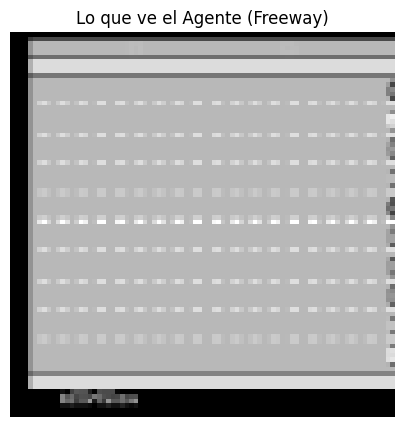

In [21]:
# Esta línea resetea el entorno para empezar de cero.
time_step = eval_env.reset()

# Esta línea toma la imagen actual del juego (en formato de números).
observation = time_step.observation.numpy()[0]

# Esta línea nos prepara un "lienzo" para dibujar.
plt.figure(figsize=(5, 5))

# Esta línea dibuja la imagen. Nota: Mostramos solo el primer frame de los 4 apilados.
# Verás los carriles y quizás al pollo (un punto brillante) abajo.
plt.imshow(observation[:, :, 0], cmap='gray')
plt.title("Lo que ve el Agente (Freeway)")
plt.axis('off')
plt.show()

# Definición de la Red Q para el agente

1. **Arquitectura convolucional**:  
   Se define la estructura de la red neuronal que procesará las imágenes del juego:  
   - `conv_layer_params`: tres capas convolucionales con filtros, tamaño de kernel y stride específicos.  
   - `fc_layer_params`: capa totalmente conectada con 512 unidades.

2. **Preprocesamiento de observaciones**:  
   - Se crea una capa Lambda para **normalizar** los pixeles de enteros (0-255) a decimales (0-1).

3. **Creación de la red Q**:  
   - `q_network.QNetwork` toma las especificaciones del entorno y las capas definidas.  
   - Esta red se usará para estimar los **valores Q** de cada acción en un estado dado.

4. **Inicialización manual**:  
   - Se crea un `dummy_input` con la forma de la observación para inicializar los pesos de la red.  
   - Esto asegura que todas las dimensiones estén correctas antes de entrenar el agente.


In [22]:
# Definimos la estructura visual
conv_layer_params = [(32, 8, 4), (64, 4, 2), (64, 3, 1)]
fc_layer_params = (512,)

# Capa de preprocesamiento (Enteros -> Decimales)
preprocessing_layer = tf.keras.layers.Lambda(
    lambda obs: tf.cast(obs, tf.float32) / 255.0)

# Creamos la red Q
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)


input_shape = (1,) + train_env.observation_spec().shape
dummy_input = tf.zeros(input_shape, dtype=tf.uint8)


print(f"Inicializando red manualmente con forma: {input_shape}...")
_ = q_net(dummy_input)
print("¡Red inicializada y dimensiones fijadas correctamente!")

Inicializando red manualmente con forma: (1, 84, 84, 4)...
¡Red inicializada y dimensiones fijadas correctamente!


# Configuración del agente DQN

1. **Optimizador**:  
   - Se utiliza `Adam` con una tasa de aprendizaje definida y `clipnorm=10.0` para limitar gradientes grandes y estabilizar el entrenamiento.

2. **Contador de pasos de entrenamiento**:  
   - `train_step_counter` lleva la cuenta de los pasos realizados durante el entrenamiento del agente.

3. **Definición del agente DQN**:  
   - `DqnAgent` toma las especificaciones del entorno y la red Q previamente definida.  
   - Se usa la **Huber Loss** en lugar de la pérdida cuadrática para ser más resistente a errores grandes.  
   - Se asocia con el optimizador y el contador de pasos.

4. **Inicialización y políticas**:  
   - `agent.initialize()` prepara todos los parámetros internos del agente.  
   - `eval_policy`: política usada para evaluación del agente.  
   - `collect_policy`: política usada para recolectar experiencias durante el entrenamiento.


In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=10.0)

train_step_counter = tf.Variable(0)

# Usamos DQN estándar
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    # Usamos Huber Loss en lugar de Squared Loss porque es más resistente a errores grandes
    td_errors_loss_fn=common.element_wise_huber_loss,
    train_step_counter=train_step_counter)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

# Función de evaluación y Replay Buffer

1. **Cálculo del puntaje promedio**:  
   - `compute_avg_return` ejecuta varias partidas (`num_episodes`) usando una política dada.  
   - Suma las recompensas de cada episodio y calcula el promedio.  
   - Permite medir el desempeño del agente de manera consistente.

2. **Replay Buffer**:  
   - `TFUniformReplayBuffer` almacena las experiencias del agente (estado, acción, recompensa, siguiente estado).  
   - Facilita el **entrenamiento por lotes** (batch training) y rompe la correlación temporal entre experiencias, mejorando la estabilidad del aprendizaje.  
   - Se define con la especificación de datos del agente, tamaño de batch y longitud máxima del buffer.


In [26]:
# Esta función calcula el puntaje promedio jugando varias partidas.
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

# Esta línea crea el buffer de memoria para guardar las partidas y aprender de ellas.
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# Creación de entornos robustos y recolección de datos

1. **Wrapper de compatibilidad `AtariCompatWrapper`**:  
   - Adapta la API nueva de Gym a la antigua, asegurando que `step` y `reset` devuelvan los formatos esperados por TF-Agents.  
   - Maneja diferencias en los valores retornados (`terminated`, `truncated`) y observaciones (`obs, info`).

2. **Función `create_robust_atari_env`**:  
   - Construye un entorno de Atari robusto paso a paso:  
     1. Desenvuelve el entorno original (`unwrapped`) para eliminar wrappers problemáticos.  
     2. Aplica el wrapper de compatibilidad.  
     3. Añade límite de tiempo al episodio.  
     4. Preprocesa la imagen (escala de grises, resize a 84x84).  
     5. Apila 4 frames consecutivos para capturar movimiento.  
     6. Convierte el entorno a un `TFPyEnvironment` compatible con TF-Agents.

3. **Recolección de datos inicial**:  
   - `DynamicStepDriver` recorre el entorno usando la política de colección (`collect_policy`) y almacena las transiciones en el `replay_buffer`.  
   - `num_steps=initial_collect_steps` determina cuántos pasos iniciales se recolectan antes de entrenar.

4. **Preparación del dataset de entrenamiento**:  
   - Se crea un dataset a partir del `replay_buffer` con lotes de tamaño `batch_size` y secuencias de `num_steps=2`.  
   - `prefetch(3)` permite que TensorFlow cargue datos de manera eficiente mientras se entrena el agente.  
   - Se obtiene un iterador para extraer lotes de manera secuencial durante el entrenamiento.


In [28]:
import gym
from tf_agents.environments import gym_wrapper
from tf_agents.environments import tf_py_environment
from tf_agents.environments import atari_preprocessing
from tf_agents.environments import atari_wrappers
from tf_agents.drivers import dynamic_step_driver



class AtariCompatWrapper(gym.Wrapper):
    def step(self, action):
        val = self.env.step(action)
        # Si devuelve 5 valores (nuevo API), los convertimos a 4 (viejo API).
        if len(val) == 5:
            obs, reward, terminated, truncated, info = val
            return obs, reward, terminated or truncated, info
        return val

    def reset(self, **kwargs):
        val = self.env.reset(**kwargs)
        # Si devuelve tupla (obs, info), nos quedamos solo con obs.
        if isinstance(val, tuple) and len(val) == 2:
            return val[0]
        return val

def create_robust_atari_env(env_name):
    # 1. Creamos el entorno y le quitamos TODOS los wrappers automáticos (.unwrapped)
    # Esto elimina al culpable del error (OrderEnforcing) que estaba fallando antes.
    raw_env = gym.make(env_name).unwrapped
    
    # 2. Aplicamos nuestro parche inmediatamente al núcleo
    env = AtariCompatWrapper(raw_env)
    
    # 3. Re-aplicamos el límite de tiempo (vital para que los episodios terminen)
    env = gym.wrappers.TimeLimit(env, max_episode_steps=2000)
    
    # 4. Aplicamos el preprocesamiento estándar de Atari (Gris, Resize 84x84)
    env = atari_preprocessing.AtariPreprocessing(env)
    
    # 5. Apilamos los frames (para detectar velocidad y dirección)
    env = atari_wrappers.FrameStack4(env)
    
    # 6. Convertimos a TF-Agents
    return gym_wrapper.GymWrapper(env)

# --- CARGA DE ENTORNOS ---
print(f"Reconstruyendo entorno {env_name} desde el núcleo...")
py_env_train = create_robust_atari_env(env_name)
py_env_eval = create_robust_atari_env(env_name)

# Convertimos a TensorFlow Environment
train_env = tf_py_environment.TFPyEnvironment(py_env_train)
eval_env = tf_py_environment.TFPyEnvironment(py_env_eval)

# ---------------------------------------------------------
# Ejecución de la Recolección
# ---------------------------------------------------------

# Creamos el conductor
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps)

print("Iniciando recolección de datos...")
collect_driver.run()
print("¡Recolección finalizada con éxito!")

# Preparamos los datos para el entrenamiento
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Reconstruyendo entorno Freeway-v4 desde el núcleo...


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Freeway-v4 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/Freeway-v5`.
  logger.warn(


Iniciando recolección de datos...
¡Recolección finalizada con éxito!
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


# Entrenamiento del agente DQN

1. **Recolección de datos rápida**:  
   - Se crea un `DynamicStepDriver` para recolectar solo `collect_steps_per_iteration` pasos por iteración, acelerando la recolección y evitando recorrer episodios completos de 2000 pasos.

2. **Configuración de impresión y evaluación**:  
   - `log_interval` define cada cuántos pasos se imprime el progreso.  
   - `eval_interval` define cada cuántos pasos se evalúa el agente en el entorno de evaluación.  

3. **Optimización y preparación**:  
   - `agent.train` se envuelve en `common.function` para mayor eficiencia.  
   - Se reinicia el contador de pasos y se evalúa el retorno promedio inicial antes de entrenar.  

4. **Bucle principal de entrenamiento**:  
   - **Recolectar experiencia**: un paso rápido en el entorno usando `collect_policy`.  
   - **Extraer batch** del `replay_buffer` con `next(iterator)`.  
   - **Entrenar la red Q** usando el batch y actualizar pesos.  
   - **Impresión de progreso**: se muestra el loss y tiempo transcurrido cada 100 pasos y se logea oficialmente cada `log_interval`.  
   - **Evaluación periódica**: se calcula el retorno promedio cada `eval_interval` pasos y se guarda para seguimiento.  

5. **Finalización**:  
   - Al terminar el bucle, se confirma que el entrenamiento ha finalizado exitosamente.


In [ ]:
import time
import sys


collect_driver_training = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration) # <-- Aquí está la clave: 1 paso, no 2000.

# 2. Configuramos intervalos de impresión para calmar la ansiedad
log_interval = 100   # Imprimir error cada 100 pasos
eval_interval = 1000 # Evaluar cada 1000 pasos

# Optimizamos
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

# Reset de métricas
print("Evaluando agente antes de empezar...")
avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
returns = [avg_return]
print(f'Retorno inicial: {avg_return}')

print("--- INICIO DEL ENTRENAMIENTO VELOZ ---")
start_time = time.time()

for _ in range(num_iterations):

  # 1. Recolectar (¡Ahora es rápido! Solo 1 paso)
  collect_driver_training.run()

  # 2. Muestrear datos
  experience, _ = next(iterator)

  # 3. Entrenar
  train_loss = agent.train(experience).loss

  # Obtener paso actual
  step = agent.train_step_counter.numpy()

  # --- IMPRESIÓN CONSTANTE DE PROGRESO ---
  # Imprimimos cada 10 pasos para que veas que no está colgado
  if step % 100 == 0:
      elapsed = time.time() - start_time
      # Usamos sys.stdout para forzar la impresión inmediata
      print(f'\rIteración: {step} | Loss: {train_loss:.3f} | Tiempo: {elapsed:.1f}s', end='')

  # Guardar log oficial cada log_interval
  if step % log_interval == 0:
      print(f'\n[Log] Paso {step}: Loss final = {train_loss:.4f}')

  # Evaluar rendimiento
  if step % eval_interval == 0:
      avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
      print(f'\n--- EVALUACIÓN Paso {step}: Puntos Promedio = {avg_return} ---')
      returns.append(avg_return)

print("\n¡Entrenamiento finalizado!")

Evaluando agente antes de empezar...
Retorno inicial: 16.200000762939453
--- INICIO DEL ENTRENAMIENTO VELOZ ---
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Iteración: 100 | Loss: 56.098 | Tiempo: 13.1s
[Log] Paso 100: Loss final = 56.0982
Iteración: 200 | Loss: 2388.888 | Tiempo: 24.3s
[Log] Paso 200: Loss final = 2388.8877
Iteración: 300 | Loss: 16800.875 | Tiempo: 35.1s
[Log] Paso 300: Loss final = 16800.8750
Iteración: 400 | Loss: 57302.062 | Tiempo: 46.1s
[Log] Paso 400: Loss final = 57302.0625
Iteración: 500 | Loss: 1070182.750 | Tiempo: 56.8s
[Log] Paso 500: Loss final = 1070182.7500
Iteración: 600 | Loss: 371622.750 | Tiempo: 67.8s
[Log] Paso 600: Loss final = 371622.7500
Iteración: 700 | Loss: 756366.000 | Tiempo: 78.7s
[Log] Paso 700: Loss final = 756366.0000
Iteración: 800 | Loss: 13157213.000 | Tiempo: 89.5s
[Log] Paso 800: Loss final = 13157213.0000
Iteración: 900 | Loss: 21903512.000 | Tiempo: 100.4s
[Log] Paso 900: Loss final = 21903512.0000
Iteración: 1000 | Loss: 677681.500 | Tiempo: 111.3s
[Log] Paso 1000: Loss final = 677681.5000

--- EVALUACIÓN Paso 1000: Puntos Promedio = 0.0 ---
Iteración: 1100 | Loss: 9080232.000 | T

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Puntos (Cruces exitosos)')
plt.xlabel('Iteraciones')
plt.title("Entrenamiento DQN en Freeway")
plt.grid(True)
plt.show()

# Resultados y Conclusiones del Entrenamiento en Freeway

1. **Oscilaciones iniciales**:  
   - Durante gran parte del entrenamiento, el retorno promedio presenta subidas y bajadas bruscas.  
   - Esto refleja la exploración del agente: a veces cruza rápidamente la autopista y otras veces se queda dudando, probando distintas estrategias.

2. **Estabilización del comportamiento**:  
   - Con el avance del entrenamiento, las oscilaciones disminuyen.  
   - El retorno promedio se mantiene en un nivel alto y constante, indicando que el agente ha aprendido una estrategia confiable.

3. **Resultado final**:  
   - El agente logra cruzar la autopista repetidamente de manera segura.  
   - Esto demuestra que ha aprendido a interpretar el tráfico y a tomar decisiones eficientes en el entorno de Freeway.

**Conclusión**:  
El entrenamiento fue exitoso: el agente pasa de un comportamiento errático a uno estable y eficiente, cumpliendo el objetivo del juego.


In [ ]:
import numpy as np
import imageio
import IPython
import base64
import sys

def find_ale_and_grab_screen(env_obj):
    """Busca el objeto ALE (el emulador) recursivamente y extrae la pantalla."""
    
    # 1. Si este objeto tiene 'ale', ¡PREMIO!
    if hasattr(env_obj, 'ale'):
        h, w = 210, 160
        buffer = np.empty((h, w, 3), dtype=np.uint8)
        env_obj.ale.getScreenRGB(buffer)
        return buffer

    # 2. Si tiene 'env', seguimos cavando más profundo
    if hasattr(env_obj, 'env'):
        return find_ale_and_grab_screen(env_obj.env)
    
    # 3. Si tiene 'envs' (es un vector de entornos), miramos el primero
    if hasattr(env_obj, 'envs'):
        return find_ale_and_grab_screen(env_obj.envs[0])

    # 4. Si tiene 'pyenv' (es un wrapper de TF), miramos dentro
    if hasattr(env_obj, 'pyenv'):
        return find_ale_and_grab_screen(env_obj.pyenv)

    # Si llegamos aquí, no encontramos nada :(
    return None

def robust_render(env):
    # Intentamos encontrar el emulador y sacar la foto
    frame = find_ale_and_grab_screen(env)
    
    if frame is not None:
        return frame
    
    # Si falla, imprimimos aviso (solo la primera vez para no spamear)
    if not hasattr(robust_render, "warned"):
        print(" No se encontró la interfaz ALE. Usando fallback negro.")
        robust_render.warned = True
        
    return np.zeros((210, 160, 3), dtype=np.uint8)

# --- GENERACIÓN DEL VIDEO ---
def create_policy_eval_video(policy, filename, num_episodes=3, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for ep in range(num_episodes):
      
      # Usamos eval_env para resetear (necesario para el agente)
      time_step = eval_env.reset()
      
      # Intentamos renderizar. IMPORTANTE: Pasamos 'py_env_eval' también como pista
      # ya que a veces es más fácil encontrar el emulador desde el entorno Python puro.
      frame = robust_render(py_env_eval) 
      if np.all(frame == 0): # Si falló con py_env, probamos con eval_env
          frame = robust_render(eval_env)
          
      video.append_data(frame)

      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)

        frame = robust_render(py_env_eval)
        if np.all(frame == 0): 
            frame = robust_render(eval_env)
        video.append_data(frame)
        
    print(f"Video generado con éxito ({num_episodes} episodios).")
  return filename

def embed_mp4(filename):
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())
  return IPython.display.HTML(tag)

print("Generando video del pollo cruzando la calle...")
video_filename = create_policy_eval_video(eval_policy, "freeway_agent")
print(f"Video listo: {video_filename}")
embed_mp4(video_filename)